# Data Import

In [76]:
from ctypes import windll
from typing import NamedTuple, Optional


class PizzaRequest(NamedTuple):
    """
    A class to represent a raw pizza request from the dataset.
    """
    
    giver_username_if_known: Optional[str]
    in_test_set: bool
    number_of_downvotes_of_request_at_retrieval: int
    number_of_upvotes_of_request_at_retrieval: int
    post_was_edited: bool
    request_id: str
    request_number_of_comments_at_retrieval: int
    request_text: str
    request_text_edit_aware: str
    request_title: str
    requester_account_age_in_days_at_request: float
    requester_account_age_in_days_at_retrieval: float
    requester_days_since_first_post_on_raop_at_request: float
    requester_days_since_first_post_on_raop_at_retrieval: float
    requester_number_of_comments_at_request: int
    requester_number_of_comments_at_retrieval: int
    requester_number_of_comments_in_raop_at_request: int
    requester_number_of_comments_in_raop_at_retrieval: int
    requester_number_of_posts_at_request: int
    requester_number_of_posts_at_retrieval: int
    requester_number_of_posts_on_raop_at_request: int
    requester_number_of_posts_on_raop_at_retrieval: int
    requester_number_of_subreddits_at_request: int
    requester_received_pizza: bool
    requester_subreddits_at_request: list[str]
    requester_upvotes_minus_downvotes_at_request: int
    requester_upvotes_minus_downvotes_at_retrieval: int
    requester_upvotes_plus_downvotes_at_request: int
    requester_upvotes_plus_downvotes_at_retrieval: int
    requester_user_flair: str
    requester_username: str
    unix_timestamp_of_request: float
    unix_timestamp_of_request_utc: float

In [77]:
import json
from pathlib import Path

def read_data(data_path) -> list[PizzaRequest]:
    """
    Read the data from the given path and return a list of PizzaRequest objects.
    :param data_path: string path to the data file relative to the current working directory
    :return: A parsed list of PizzaRequest objects
    """
    filepath = Path.cwd() / Path(data_path)

    if not filepath.exists():
        raise FileNotFoundError(
            f"File not found: {filepath}; " +
            f"Current working directory: {Path.cwd()}; " +
            f"Relative path to data file: {Path(data_path)}"
        )

    print(f"Using file: {filepath.absolute()}")

    with filepath.open("r", encoding="UTF-8") as file:
        raw_data = json.load(file)
        # Turn loaded dict into a list of PizzaRequest objects
        return [
            PizzaRequest(**datapoint)
            for datapoint
            in raw_data
        ]


## Load the data creating the graph

In [78]:
## CAPITALIZED because they are 'constants' which shouldn't be reassigned

# load the data
RAW_DATA = read_data("./dataset/pizza_request_dataset.json")

# create a pandas dataframe
import pandas as pd
DATAFRAME = pd.DataFrame(RAW_DATA)

# use requester_username and giver_username_if_known to create a networkx graph

import networkx as nx
GRAPH = nx.DiGraph()

## We don't need this because the nodes are automatically added when we add edges
#
# create a set of usernames for both requester and giver
# usernames = set()
# usernames.add(row.requester_username for row in RAW_DATA)
# usernames.add(row.giver_username_if_known for row in RAW_DATA)
# 
# # delete None values
# usernames.discard(None)
# 
# # add nodes to the graph
# GRAPH.add_nodes_from(usernames)

# add edges between requester and giver
GRAPH.add_edges_from(
    (row.giver_username_if_known, row.requester_username)
    for row in RAW_DATA
    if row.giver_username_if_known != "N/A"
)

# add edges to subreddits
# GRAPH.add_edges_from(
#     (row.requester_username, subreddit)
#     for row in RAW_DATA
#     for subreddit in row.requester_subreddits_at_request
# )

Using file: C:\Users\majerm\projects\private\github\rug-sna-pizza-giving\dataset\pizza_request_dataset.json


# Data Exploration

In [79]:
# print the number of nodes and edges
print(f"Number of nodes: {GRAPH.number_of_nodes()}")
print(f"Number of edges: {GRAPH.number_of_edges()}")

Number of nodes: 727
Number of edges: 400


In [80]:
# Group the data by givers, and sort by those who gave the most pizzas
(DATAFRAME.groupby("giver_username_if_known")
 .size()
 .sort_values(ascending=False)
 .head(10))

giver_username_if_known
N/A                5271
pastafariantwit       7
jetboyterp            6
johngalt1337          6
m2nu                  6
mr_jeep               5
thr                   5
tanyagal2             4
harrisonfire          4
incoherentrant        3
dtype: int64

In [81]:
# Group the data by requesters, and sort by those who received the most pizzas
(DATAFRAME.groupby("requester_username")
 .size()
 .sort_values(ascending=False)
 .head(10))

requester_username
zzisrafelzz           1
-Magitek-Armor-       1
-idk                  1
-notagirl-            1
0110110101101100      1
0b4m4                 1
0o00o00o0o00o0oooO    1
yun-                  1
yungbroccoli          1
yupitsaslie           1
dtype: int64

> *You can request at most a single pizza, but you can give multiple pizzas*
> 
> pastafariantwit gave 7 pizzas, and everyone received at most 1 pizza

Size of givers: 4
Size of requestors: 25


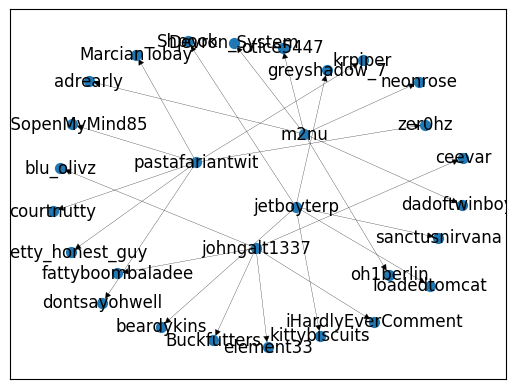

In [82]:
# Draw the graph
import matplotlib.pyplot as plt 
# nx.draw(GRAPH, with_labels=False, font_weight='bold')

# Draw only nodes with more than 5 out degree along with the edges and nodes connected to them

pizza_givers = set(
    giver for giver in GRAPH.nodes
    if 5 < GRAPH.out_degree(giver)
)

# flatmap the successors of the givers
pizza_eaters = set(
    eater 
    for giver in pizza_givers
    for eater in GRAPH.successors(giver)
)

print(f"Size of givers: {len(pizza_givers)}")
print(f"Size of requestors: {len(pizza_eaters)}")

subgraph = GRAPH.subgraph(pizza_givers | pizza_eaters)

# Drawing keywords: https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html#networkx.drawing.nx_pylab.draw_networkx

DRAW_DEFAULTS = { 
    "node_size": 50, 
    "width": .2,
}

nx.draw_networkx(
    subgraph, 
    **DRAW_DEFAULTS
)

# Algorithms: https://networkx.org/documentation/stable/reference/algorithms/index.html

## Centralities

colormap of centralities:

Degree
Eigenvector
Closeness
Current Flow Closeness
(Shortest Path) Betweenness
Current Flow Betweenness
Communicability Betweenness
Group Centrality
Load
Subgraph
Harmonic Centrality
Dispersion
Reaching
Percolation
Second Order Centrality
Trophic
VoteRank
Laplacian

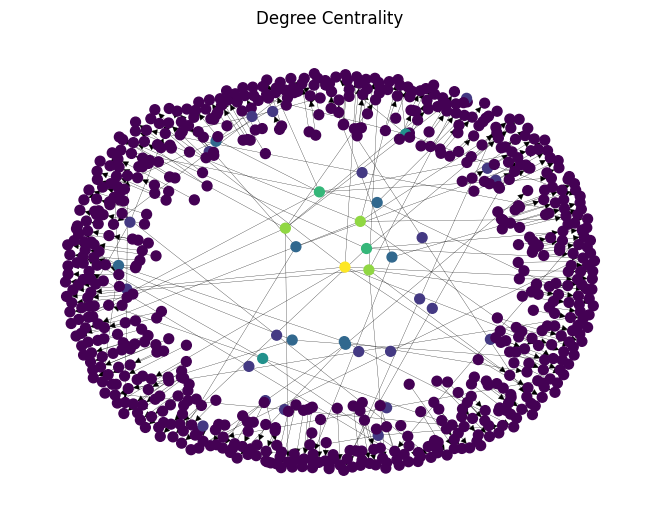

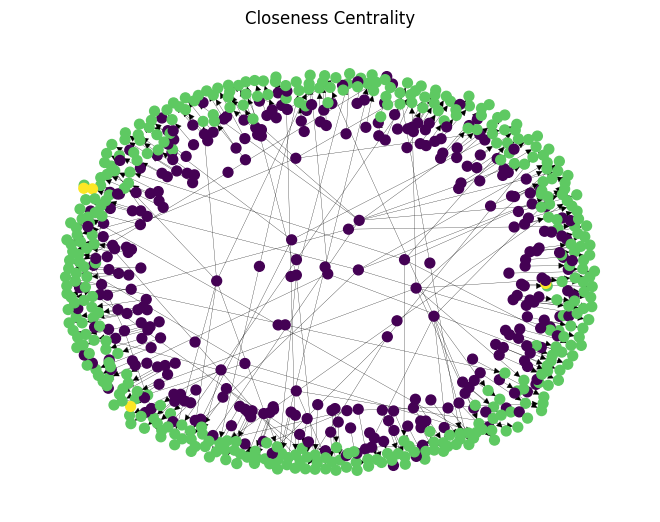

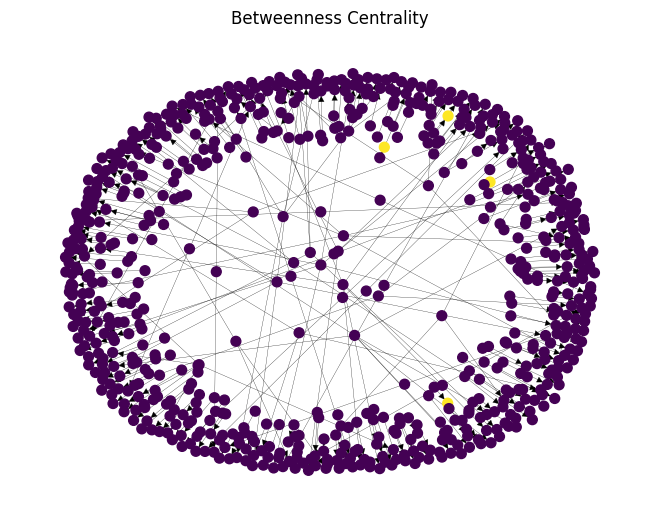

In [83]:
# Create colormaps for all centralities, into one plot 

def draw_colored_graph(graph, centrality, title):
    """
    Draw the graph with nodes colored by the given centrality.
    :param graph: The graph to draw
    :param centrality: The centrality to use for coloring the nodes
    :param title: The title of the plot
    """
    # Get the values of the centrality
    values = list(centrality.values())
    
    # Draw the graph, with a colorbar
    colormap = plt.get_cmap("viridis")
    nx.draw(
        graph,
        **DRAW_DEFAULTS,
        node_color=values, 
        cmap=colormap, 
        with_labels=False,
    )
    # plt.colorbar(plt.cm.ScalarMappable(cmap=colormap), cax=ax.inset_axes([0.95, 0.1, 0.05, 0.8]), label=title)
    plt.title(title)
    plt.show()
    
draw_colored_graph(GRAPH, nx.degree_centrality(GRAPH), "Degree Centrality")
# draw_colored_graph(GRAPH, nx.eigenvector_centrality(GRAPH), "Eigenvector Centrality")
draw_colored_graph(GRAPH, nx.closeness_centrality(GRAPH), "Closeness Centrality")
draw_colored_graph(GRAPH, nx.betweenness_centrality(GRAPH), "Betweenness Centrality")
# draw_colored_graph(GRAPH, nx.current_flow_betweenness_centrality(GRAPH), "Current Flow Betweenness Centrality")
# draw_colored_graph(GRAPH, nx.communicability_betweenness_centrality(GRAPH), "Communicability Betweenness Centrality")
# draw_colored_graph(GRAPH, nx.load_centrality(GRAPH), "Load Centrality")
# draw_colored_graph(GRAPH, nx.harmonic_centrality(GRAPH), "Harmonic Centrality")
# draw_colored_graph(GRAPH, nx.dispersion(GRAPH), "Dispersion")
# draw_colored_graph(GRAPH, nx.reaching_centrality(GRAPH), "Reaching Centrality")
# draw_colored_graph(GRAPH, nx.second_order_centrality(GRAPH), "Second Order Centrality")
# draw_colored_graph(GRAPH, nx.trophic_centrality(GRAPH), "Trophic Centrality")
# draw_colored_graph(GRAPH, nx.voterank(GRAPH), "VoteRank")
# draw_colored_graph(GRAPH, nx.laplacian_centrality(GRAPH), "Laplacian Centrality")


## Density, Connectedness, and Components

In [84]:
#density
print(f"Density: {nx.density(GRAPH)}")
nx.degree_histogram(GRAPH)

Density: 0.0007578599550589046


[0, 689, 22, 8, 2, 2, 3, 1]